### Create features without filtering things out
---

* Model Design Feedback:
    * Make the target less restrictive
        * ACH return in 3 days
        * Consider Indeterminate...this is what essentially make model look better
    * Candidates: 
        * Account balance < 0
        * Closed by risk, write off, charged off
    * Use more recent data, when Plaid is available.
        * Check availability of Plaid features
    * Drop Giact features



In [1]:
import pandas as pd
import numpy as np
import category_encoders
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

%load_ext autoreload
%autoreload 2

In [2]:
%time transactions_df = pd.read_feather('../../data/features/features_1600938572.feather')

CPU times: user 20.5 s, sys: 20.2 s, total: 40.7 s
Wall time: 7.05 s


<AxesSubplot:>

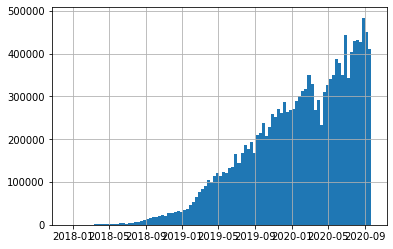

In [3]:
transactions_df.transaction_datetime.hist(bins=100)

In [4]:
transactions_df.transaction_datetime.max()

Timestamp('2020-09-22 02:51:45')

### Calc labels
---

In [5]:
from tqdm import tqdm 
from pandas.tseries.offsets import BDay
from multiprocessing import Pool, cpu_count


### Helper functions
def reverse_df(df):
    """ Helper for forward looking rolling function """
    # reverse dataset
    reverse_df = df.iloc[::-1]
    ri = reverse_df.index

    # re-reverse index
    reverse_df.index = ri[0] - ri + ri[-1]

    return reverse_df

## Need to define forward looking roll-ups at top level to parallelize.
def get_nr_returns_5d(df):
    return reverse_df(reverse_df(df).rolling('5d', min_periods=1)['is_return'].sum())

def get_bal_after_5d(df):
    return reverse_df(reverse_df(df).rolling('5d', min_periods=1)['real_ending_balance'].apply(lambda a: a[0], raw=True))

def applyParallel(dfGrouped, func):
    """ Helper to parallelize apply over groupby """
    with Pool(cpu_count()) as p:
        ret_list = p.map(func, [group for name, group in dfGrouped])
    return pd.concat(ret_list)

def stupid_hack(x):
    try:
        return x[-1]
    except:
        return x


def match_ach_returns(df, timedelta=BDay(3)):
    """
    Check if ACH transactions are returned with some timeframe.
    """
    #For performance purposes...
    df = df[df['transaction_code'].isin(['ACHDD', 'DWACHRET'])]
    
    # df = df.reset_index(drop=True)

    df['tamt_abs'] = df['transaction_amount'].abs()
    df['is_returned'] = False
    
    for act_n, transaction in tqdm(df[df['is_return'] == 1].iterrows()):
        
        tdt_hi = transaction['transaction_datetime']
        tdt_lo = tdt_hi - timedelta

        dcandidate = df[df['business_account_number'] == transaction['business_account_number']]

        dret = dcandidate[(dcandidate['transaction_datetime'].between(tdt_lo, tdt_hi)) & \
                          (dcandidate['tamt_abs'] == transaction['tamt_abs'])]
        
        df.loc[dret.index, 'is_returned'] = True

#     df = df.reset_index(drop=True)
    return df

def get_labels(df):
    """
    Get add labels to processed data.
    """    
    # sort data for roll-ups
    df = df.sort_values(by=['business_account_number', 'transaction_datetime'])

    df['days_to_acc_close'] = (pd.to_datetime(df['dtc']) - df['transaction_datetime']).dt.days
    df['account_closed_by_risk_in_next_90d'] = df['closed_reason'].isin(['Closed by SoFi - Risk Request', 
                                                                         'Closed by SoFi - Charge-Off / Write-Off']) &\
                                               (df['days_to_acc_close'] <= 90)
    
    # does account chg/wrt off in next 90 days?
    df['is_chg_wrt_off_in_90d'] = (df['chg_wrt_off_date'] - df['transaction_datetime']).dt.days <= 90

    # Set index to transaction datetime.
    df = df.set_index('transaction_datetime')

    # get num returns by borrower in the next 90 days
    df['nr_returns_in_next_5d'] = applyParallel(df[['business_account_number', 'is_return']].groupby('business_account_number'), get_nr_returns_5d).values
    
    # get this borrower's account balance after 90 days
    df['bal_after_5d'] = applyParallel(df[['business_account_number', 'real_ending_balance']].groupby('business_account_number'), get_bal_after_5d).values

    df = df.reset_index()

#     df = match_ach_returns(df)
    
#     def get_target(df):
#         """
#         for now: bad if this transaction is returned in next 3 business days, good otherwise.
        
#         Note: want to exclude/indeterminate R10 returns* -- Notex2 - decided not to do this since it's too imprecise.

#         BAD - this specific ACH transaction returns within the next 3 business days.
#         Consider indeterminating accounts with ++ balance that have returns, not closed off by risk
#         and accounts with no ach return but closed off by risk.
#         """
#         df['target'] = df['is_returned']
        
#         df['indeterminate'] = (df['target'] & ((df['bal_after_90d'] > 0) & 
#                                              (~df['account_closed_by_risk_in_next_90d']))) \
#                               | (~df['target'] & df['account_closed_by_risk_in_next_90d'])
        
#         return df

#     df = get_target(df)
    
    if 'level_0' in df.columns:
        df = df.drop('level_0', axis=1)
    
    return df  

In [6]:
# drop non ACH types
def drop_non_ach(df):
    df = df[df['transaction_code'].isin(['ACHDD']) & (df['transaction_amount'] > 0)]
    return df

In [7]:
# transaction_amount may be + or - based on whether it is a deposit or expense

In [20]:
cols = """
business_account_number
transaction_datetime
dtc
closed_reason
chg_wrt_off_date
is_return
real_ending_balance
transaction_code
transaction_amount
""".split()

In [21]:
%time transactions_df_ = get_labels(transactions_df[cols])

CPU times: user 3min 22s, sys: 13.4 s, total: 3min 36s
Wall time: 3min 45s


In [22]:
# transactions_df.to_parquet('../../artifacts/20200920/transactions_df_unlabeled.parquet')

### To match_ach rmatch_ach_returns

In [23]:
# transactions_df = pd.read_parquet('../../artifacts/20200920/transactions_df_unlabeled.parquet')

In [24]:
transactions_df_.columns

Index(['transaction_datetime', 'business_account_number', 'dtc',
       'closed_reason', 'chg_wrt_off_date', 'is_return', 'real_ending_balance',
       'transaction_code', 'transaction_amount', 'days_to_acc_close',
       'account_closed_by_risk_in_next_90d', 'is_chg_wrt_off_in_90d',
       'nr_returns_in_next_5d', 'bal_after_5d'],
      dtype='object')

In [25]:
import warnings
warnings.filterwarnings(action='ignore')

transactions_df__ = match_ach_returns(transactions_df_)

23112it [01:15, 307.58it/s]


In [26]:
transactions_df.shape, transactions_df_.shape, transactions_df__.shape

((15295228, 163), (15295228, 14), (687179, 16))

In [30]:
transactions_df.index.max(), transactions_df_.index.max(), transactions_df__.index.max()

(15295227, 15295227, 15295227)

### Check columns and assign values

In [39]:
# for col in transactions_df_.columns:
#     if col in transaction_df.columns:
#         print(f"column {col} equals? {transactions_df[col].equals(transactions_df_[col])}")
#     else:
#         transaction_df[col] = np.nan
#         idx = transactions_df_.index
#         transactions_df.loc[idx, col] = transactions_df_[col]

In [48]:
def combine_df_by_idx(df1, df2):
    for col in df2.columns:
        idx = df2.index
        if col in df1.columns:
            print(f"column {col} equals? {df1.loc[idx, col].equals(df2[col])}")
        else:
            print(f"adding column {col}")
            df1[col] = np.nan
            df1.loc[idx, col] = df2[col]
    return df1

In [49]:
# debug_df__ = transactions_df__.head(1000).copy()
# debug_df_ = transactions_df_.head(debug_df_.index.max()+1)
# display(debug_df_.shape, debug_df__.shape)
# debug_df_ = combine_df_by_idx(debug_df_, debug_df__)

(21544, 14)

(1000, 16)

column transaction_datetime equals? True
column business_account_number equals? True
column dtc equals? True
column closed_reason equals? True
column chg_wrt_off_date equals? True
column is_return equals? True
column real_ending_balance equals? True
column transaction_code equals? True
column transaction_amount equals? True
column days_to_acc_close equals? True
column account_closed_by_risk_in_next_90d equals? True
column is_chg_wrt_off_in_90d equals? True
column nr_returns_in_next_5d equals? True
column bal_after_5d equals? True
adding column tamt_abs
adding column is_returned


In [56]:
transactions_df = combine_df_by_idx(transactions_df, transactions_df_)
transactions_df = combine_df_by_idx(transactions_df, transactions_df__)

column transaction_datetime equals? True
column business_account_number equals? True
column dtc equals? True
column closed_reason equals? True
column chg_wrt_off_date equals? True
column is_return equals? True
column real_ending_balance equals? True
column transaction_code equals? True
column transaction_amount equals? True
adding column days_to_acc_close
adding column account_closed_by_risk_in_next_90d
adding column is_chg_wrt_off_in_90d
adding column nr_returns_in_next_5d
adding column bal_after_5d
column transaction_datetime equals? True
column business_account_number equals? True
column dtc equals? True
column closed_reason equals? True
column chg_wrt_off_date equals? True
column is_return equals? True
column real_ending_balance equals? True
column transaction_code equals? True
column transaction_amount equals? True
column days_to_acc_close equals? True
column account_closed_by_risk_in_next_90d equals? True
column is_chg_wrt_off_in_90d equals? True
column nr_returns_in_next_5d equa

In [60]:
# transactions_df['tamt_abs'] = transactions_df['transaction_amount'].abs()
# transactions_df['is_returned'] = False
# idx = transactions_df_[transactions_df_.is_returned].index
# transactions_df.loc[idx, 'is_returned'] = True

In [61]:
transactions_df.to_parquet('../../artifacts/20200920/transactions_df_unlabeled.parquet')